In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_score 
warnings.filterwarnings("ignore")

# Загрузка данных

#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

column_names = ['classes', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 
                'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 
                'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
                'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 
                'ring-type', 'spore-print-color', 'population', 'habitat']
df = pd.read_csv('mushroom_agaricus-lepiota.csv', header=None, names=column_names)
categorical_features = column_names[1:]
ddf = df.copy()
# Кодирование классов
df['classes'] = df['classes'].map({'e': 0, 'p': 1})

df.head()

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,0,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,0,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,1,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,0,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


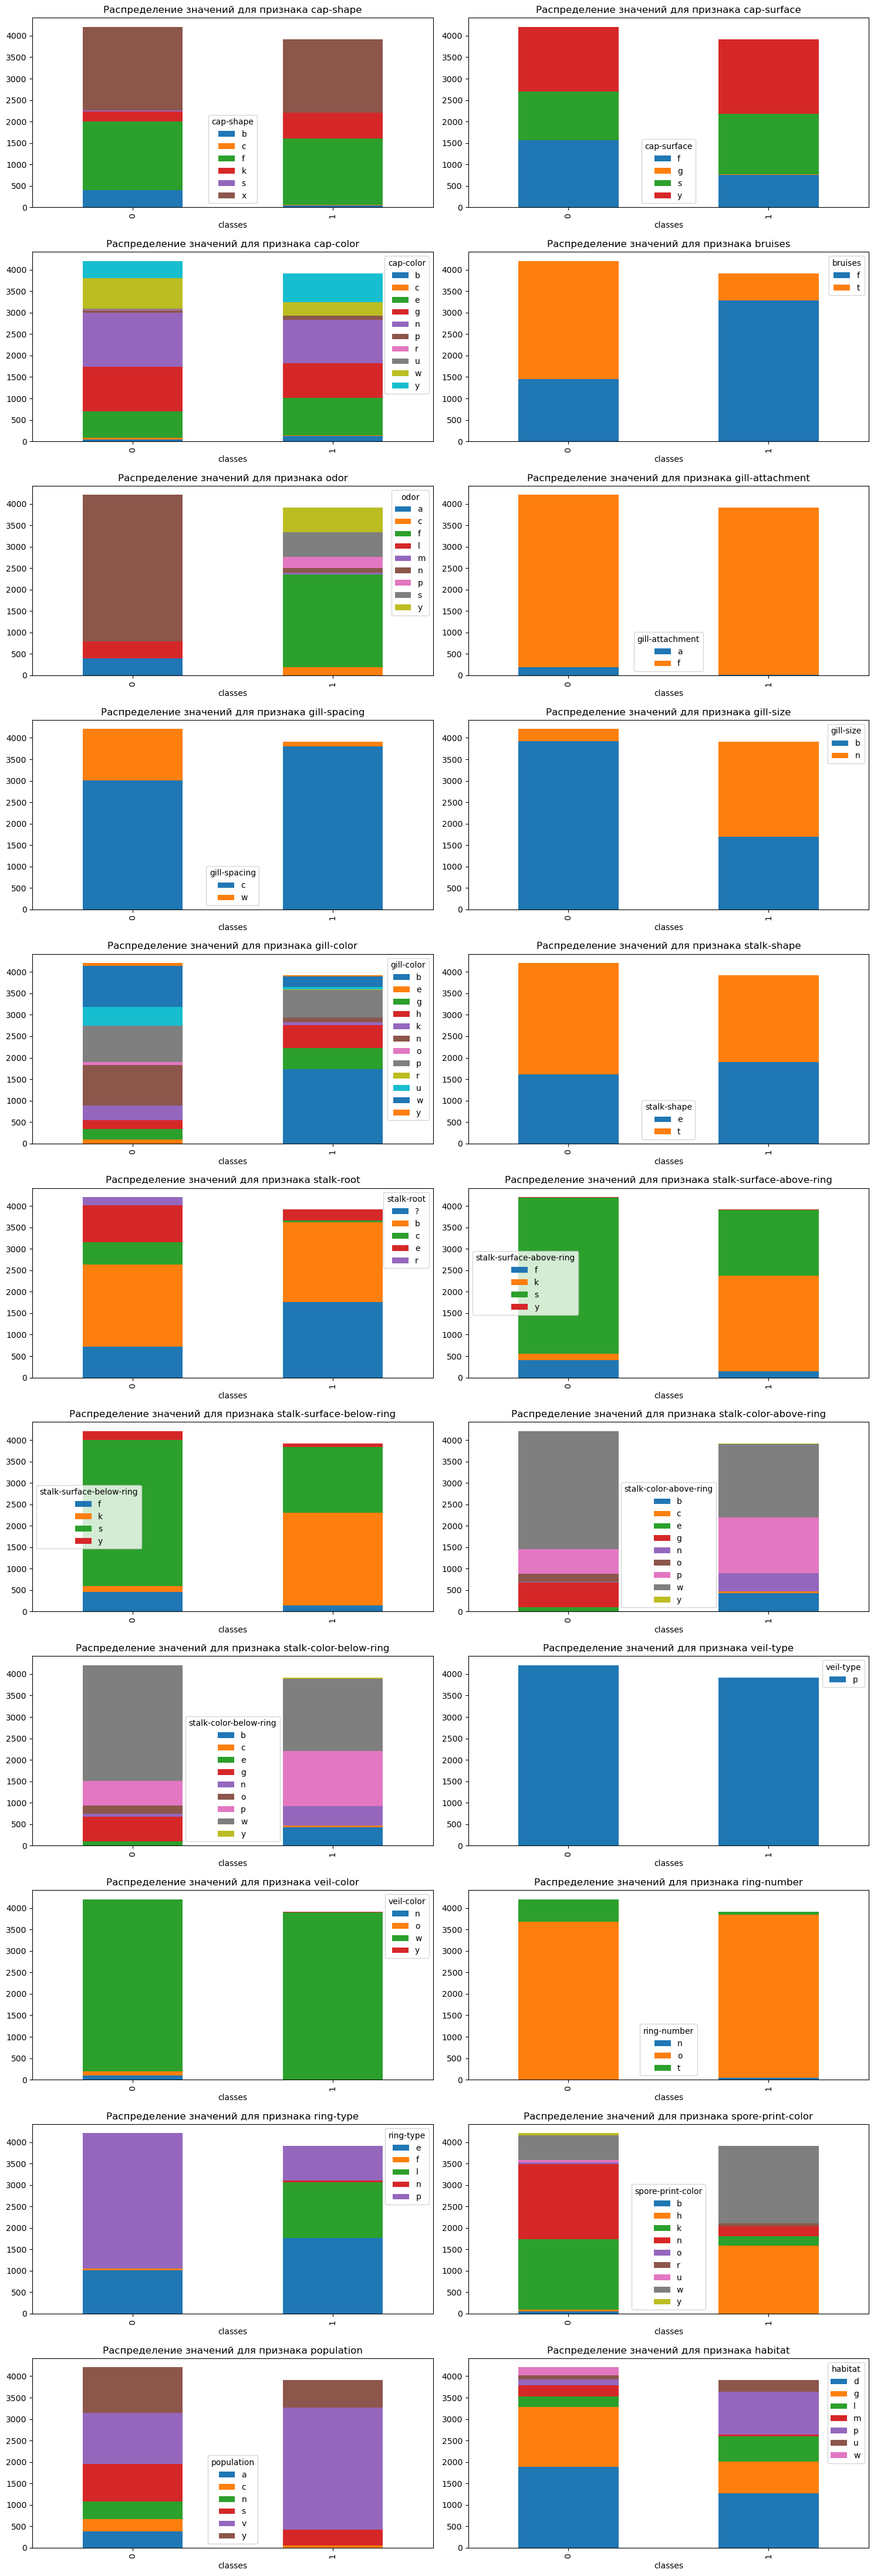

In [43]:
fig, axs = plt.subplots(len(categorical_features)//2, 2, figsize=(15, len(categorical_features)*2))

for i, feature in enumerate(categorical_features):
    df_grouped = df.groupby(['classes', feature]).size().unstack(fill_value=0)
    df_grouped.plot(kind='bar', stacked=True, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Распределение значений для признака {feature}')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import accuracy_score

# Инициализация списка для хранения точности каждой переменной
accuracies = []

# Перебор всех столбцов DataFrame
for column in df.columns[1:]:

    # Создание решающей функции на основе частот
    decision_function = df.groupby(column)['classes'].mean().round().to_dict()

    # Применение решающей функции к данным
    predictions = df[column].map(decision_function)
    
    # Вычисление точности
    accuracy = accuracy_score(df['classes'], predictions)
    
    # Добавление точности в список
    accuracies.append(accuracy)

# Нахождение наиболее информативной переменной
most_informative_variable = df.columns[accuracies.index(max(accuracies)) + 1]
print(f'Наиболее информативная переменная: {most_informative_variable}')


Наиболее информативная переменная: odor


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import numpy as np

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded[categorical_features] = encoder.fit_transform(df[categorical_features])

# Разделение данных на обучающую и тестовую выборки
X = df_encoded.drop('classes', axis=1)
y = df_encoded['classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
class NaiveBayes:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # аддитивное сглаживание
        self.class_aprior = {}  # априорных вероятности
        self.feature_cond = {}  # условные вероятности
        self.total_in_class = {}

    def fit(self, X, y):
        amount, _ = X.shape
        self.classes = np.unique(y)
        
        #Подсчёт априорных вероятностей P(y), то есть в данном случае - частоты встретить определённый класс в датасете
        for c in self.classes:
            self.class_aprior[c] = np.sum(y == c)/amount

        #Подсчёт условных вероятностей P(X|y) = P(x1=o1, x2=o2... xn=on|y), в данном случае - частоты встретить определённые значения признаков для каждого класса
        for c in self.classes:
            self.feature_cond[c] = {}

            for feature in X.columns:
                feature_counts = X[y == c][feature].value_counts() # Распределение значений признака в классе y при xi = oi для любого i
                self.total_in_class[c] = np.sum(y == c) # Общее количество примеров в классе
                self.feature_cond[c][feature] = (feature_counts + self.alpha)/(self.alpha*len(np.unique(X[y == c][feature])) + self.total_in_class[c]) # Подсчёт условных вероятностей по признакам для каждого значения признака

    def predict(self, X):
        predictions = []
        #P(y|X) = P(y)*P(X|y)/P(X) => P(y|X) ~ P(y)*P(X|y) = P(y)*P(x1=o1, x2=o2... xn=on|y)
        # ходим по строкам (разным тестировочным объектам)
        for _, row in X.iterrows():
            class_scores = {} # Словарь ln P(yi | X) 

            for c in self.classes:
                # Логарифм априорной вероятности класса
                class_scores[c] = np.log(self.class_aprior[c]) # ln P(y | X) ~  ln P(y) + ln P(X|y)

                for feature, value in row.items(): # Перебор признаков и их значений у объекта
                    if value in self.feature_cond[c][feature]: # Проверка на существования значений признаков в нашем списке условных вероятностей основаном на датасете
                        # Если значение признака присутствует в условных вероятностях, добавляем логарифм вероятности
                        # ln (P(x1=o1, x2=o2, ... xn=on|y)) = ln (P(x1=o1|y) *  P(x2=o2|y) * ... * P(xn=on|y)) = 
                        # = ln P(x1=o1|y) + ln P(x2=o2|y)+ ... + ln P(xn=on|y)
                        class_scores[c] += np.log(self.feature_cond[c][feature][value]) # ln P(xi=oi|y)
                    else:
                        # Если оказалось, что в датасете не было объекта с определённым значением признака, то
                        # Используем сглаживание для недостающих значений признака xj. xj принимает V = len(self.feature_cond[c]) различных уникальных значений в датасете.
                        # Всего признак xj встречается N = np.sum(X.columns == feature) раз
                        # ln P(xj=oj|y) = ln (alpha / (N + alpha*V))
                        class_scores[c] += np.log(self.alpha / (self.total_in_class[c] + len(self.feature_cond[c][feature]) * self.alpha))
                        
            # Выбор класса с максимальной оценкой
            predictions.append(max(class_scores, key=class_scores.get)) #Выбор максимальной вероятности между P(y1|X) и P(y2|X)
            
        return predictions

In [47]:
from sklearn.metrics import accuracy_score

# Создание и обучение нашего классификатора
nb = NaiveBayes(alpha=0)
nb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_nb = nb.predict(X_test)
# Вычисление точности
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Создание и обучение модели
model = CategoricalNB(alpha=0)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке и вычисление точности
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Точность нашего классификатора: {accuracy_nb}')
print(f'Точность библиотечного классификатора: {accuracy}')

Точность нашего классификатора: 0.9963076923076923
Точность библиотечного классификатора: 0.9963076923076923


In [132]:
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

#Создание модели и объявление основных констант
lr_model = LogisticRegression()
eps = 1e-10

# Вычисление оценок вероятностей и применение обратного логистического преобразования
prob_estimates_train = model.predict_proba(X_train) # Возвращает оценки вероятностей обученной модели NB на X_train
transformed_estimates_train = logit(prob_estimates_train.clip(eps, 1 - eps)) # Возвращает значение логита log( p / (1-p) )

# Обучение модели логистической регрессии
lr_model.fit(transformed_estimates_train, y_train) # Обучение модели LR на предответах по логиту

# Вычисление оценок вероятностей и применение обратного логистического преобразования
prob_estimates_test = model.predict_proba(X_test) # Возвращает оценки вероятностей обученной модели NB на X_train
transformed_estimates_test = logit(prob_estimates_test.clip(eps, 1 - eps)) # Применение логистического преобразования над ответами NB

# Предсказание на тестовой выборке
y_pred_lr = lr_model.predict(transformed_estimates_test) # Предсказание по предответам X_test NB обученного на X_train
y_pred_probe = lr_model.predict_proba(transformed_estimates_test)
#Вычисление точности
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f'Точность: {accuracy_lr}')


Точность: 1.0


In [192]:
# Точность модели по каждому признаку
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# предположим, что X - это ваш датасет, а y - это целевая переменная
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определите количество строк и столбцов в фигуре
num_rows = 6
num_cols = 6

result_metric = []
for i, feature in enumerate(X.columns):
    model = LogisticRegression()
    model.fit(X_train[[feature]], y_train)
    y_pred = model.predict(X_test[[feature]])
    y_pred_proba = model.predict_proba(X_test[[feature]])[:, 1]
    
    # Расчет точности
    acc = accuracy_score(y_test, y_pred)
    print(f'Точность для признака {feature}: {acc}')
    
    # Построение ROC-кривой
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    result_metric.append((fpr, tpr, auc))

Точность для признака cap-shape: 0.5027692307692307
Точность для признака cap-surface: 0.5495384615384615
Точность для признака cap-color: 0.5267692307692308
Точность для признака bruises: 0.7366153846153846
Точность для признака odor: 0.6996923076923077
Точность для признака gill-attachment: 0.5187692307692308
Точность для признака gill-spacing: 0.6203076923076923
Точность для признака gill-size: 0.7409230769230769
Точность для признака gill-color: 0.7556923076923077
Точность для признака stalk-shape: 0.5587692307692308
Точность для признака stalk-root: 0.6449230769230769
Точность для признака stalk-surface-above-ring: 0.7353846153846154
Точность для признака stalk-surface-below-ring: 0.72
Точность для признака stalk-color-above-ring: 0.5230769230769231
Точность для признака stalk-color-below-ring: 0.5236923076923077
Точность для признака veil-type: 0.5187692307692308
Точность для признака veil-color: 0.5193846153846153
Точность для признака ring-number: 0.5304615384615384
Точность дл

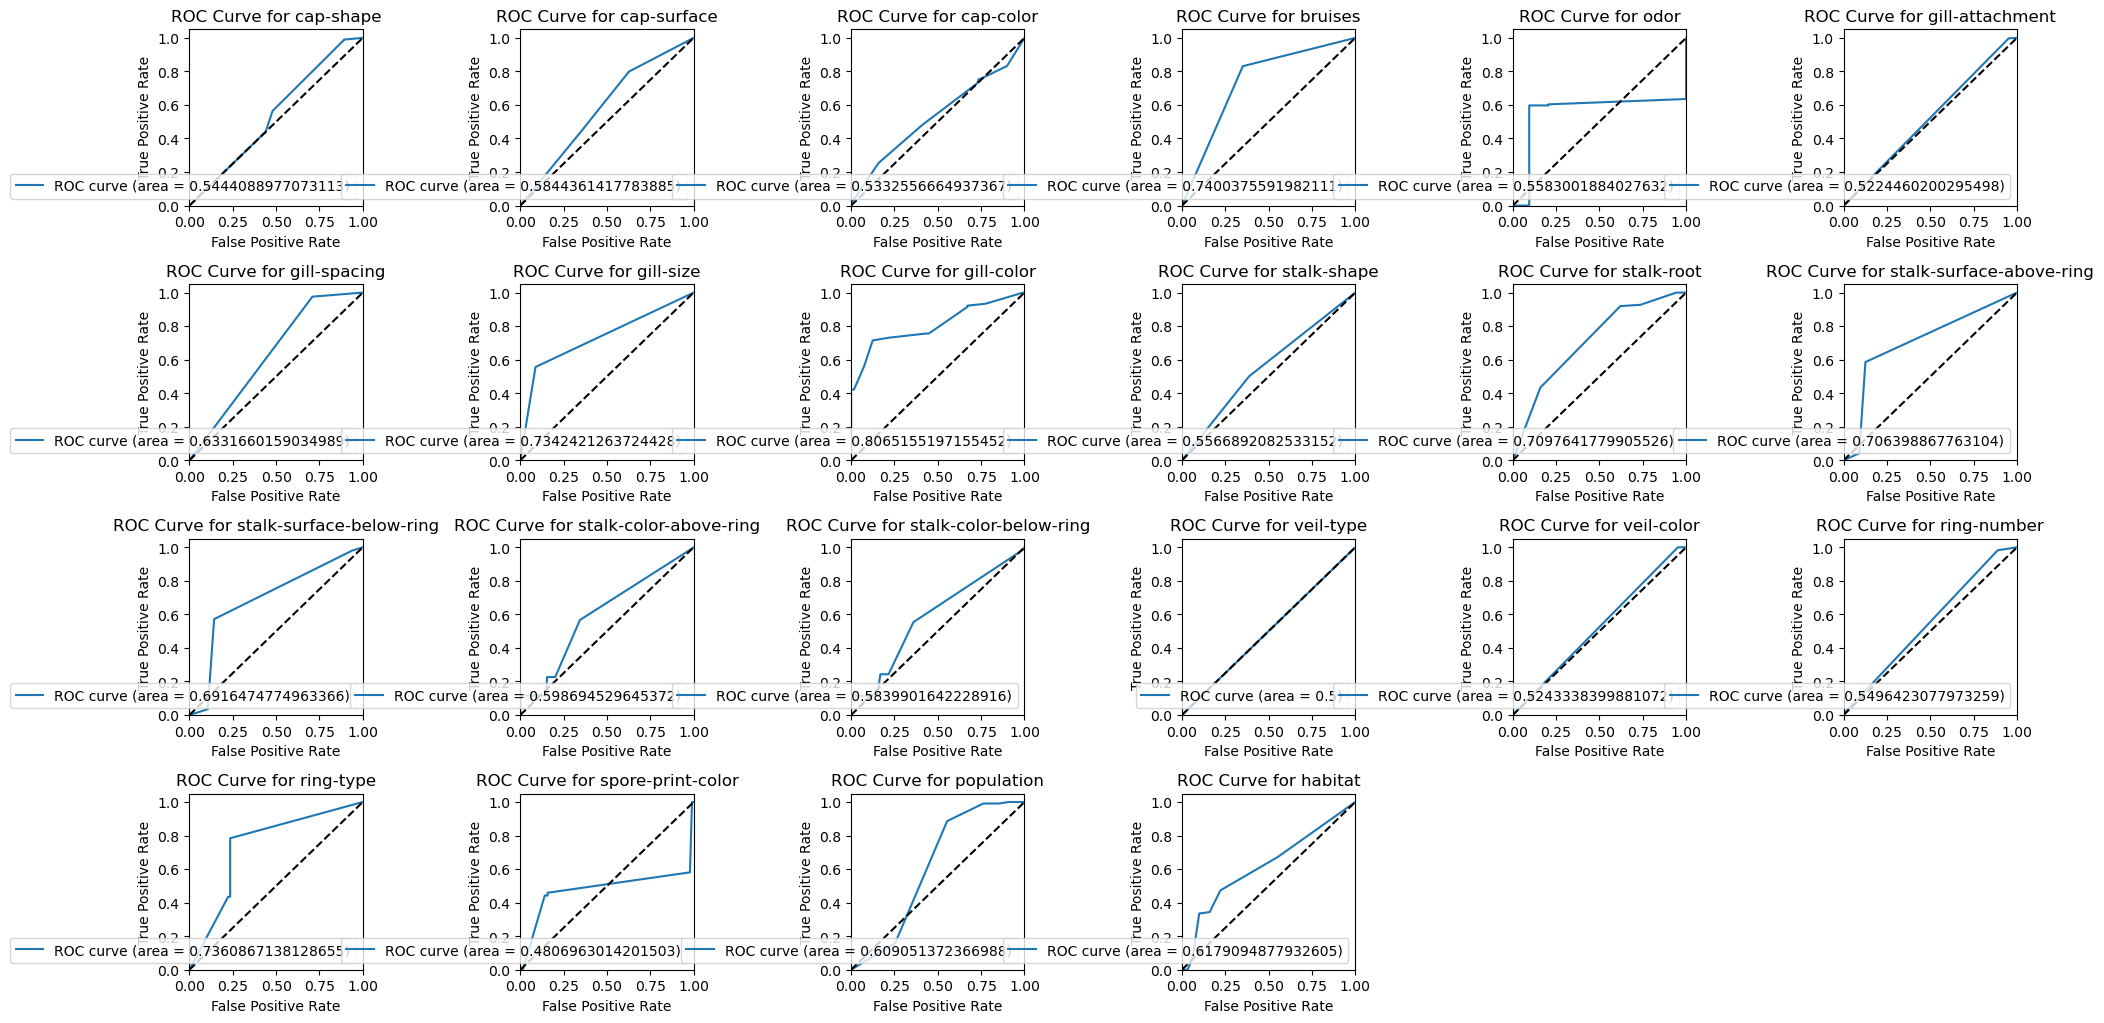

In [195]:
# Создайте фигуру с подграфиками
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Преобразуйте матрицу подграфиков в одномерный массив
axes = axes.flatten()
# Отобразите ROC-кривую на текущем подграфике
for i, (fpr, tpr, auc) in enumerate(result_metric):
    axes[i].plot(fpr, tpr, label=f'ROC curve (area = {auc})')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve for {X.columns[i]}')
    axes[i].legend(loc="lower right")
# Убедитесь, что оставшиеся подграфики не отображаются
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

# Отобразите все графики
plt.tight_layout()
plt.show()